In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Reading raster file
raster_path = "/Users/Emirhan/Desktop/MASK/WestPalm/qgis_exported/geo_velocity_epsg4326.tif"
with rasterio.open(raster_path, "r") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [3]:
#Reading shape file (vector)
shape_path = "/Users/Emirhan/Desktop/MASK/WestPalm/qgis_exported/buffered_rail.geojson"
train_df = gpd.read_file(shape_path)

In [4]:
#To check raster and vector file both have same coordinate reference system
print("CRS Raster: {}, CRS Vector {}".format(train_df.crs, src.crs))

CRS Raster: EPSG:4326, CRS Vector EPSG:4326


/var/folders/lc/h3fst5350wlcdp_gqccwx60h0000gq/T/ipykernel_42875/319245538.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


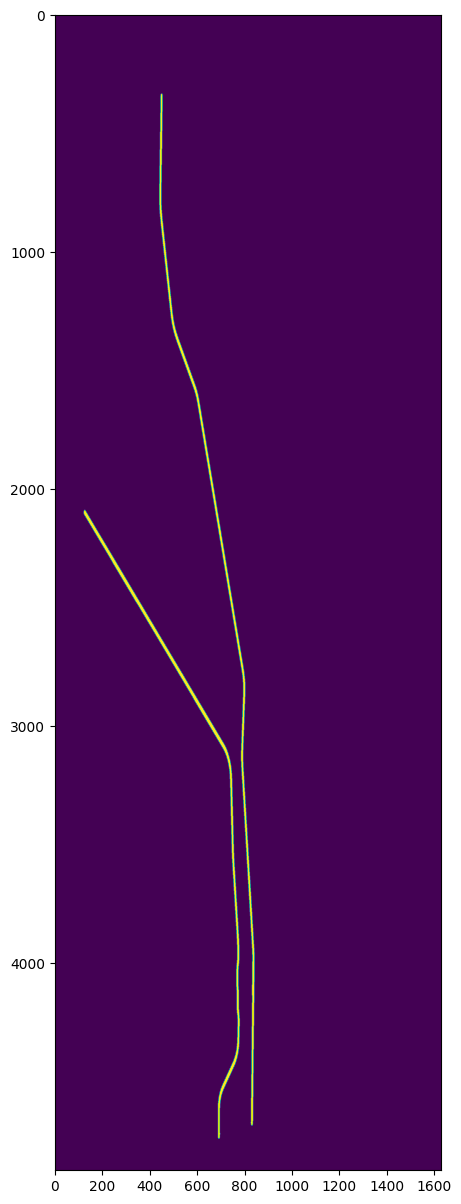

In [5]:
#Generating polygon
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # Convert polygons to the image CRS
        poly_pts.append(~transform * tuple(i))
        
    # Generate a polygon object
    new_poly = Polygon(poly_pts)
    return new_poly


# Generate Binary mask
poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    elif row['geometry'].geom_type == 'MultiPolygon':
        for p in row['geometry'].geoms:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp, out_shape=im_size)

# Convert the mask to boolean (False and True)
mask = mask.astype(bool)

# Create a single-band raster
output_meta = raster_meta.copy()
output_meta.update(count=1)

# Save the boolean mask as a single-band TIFF
output_path = "/Users/Emirhan/Desktop/MASK/WestPalm/mask_binary.tif"
with rasterio.open(output_path, 'w', **output_meta) as dst:
    dst.write(mask, 1)

# Plot the mask
plt.figure(figsize=(15, 15))
plt.imshow(mask)